# 🤒 Epidemic Mitigation Simulation

Our group project for the CS-456: Artificial Neural Networks/Reinforcement Learning course.

Team Member 1

> - 😀 Name: **Yiyang Feng**
> - ✉️ Email: **yiyang.feng@epfl.ch**
> - 🪪 SCIPER: **352042**

Team Member 2

> - 😀 Name: **Jiayi Sun**
> - ✉️ Email: **@**
> - 🪪 SCIPER: **0.0**

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from gym import spaces

# Environment imports
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

# Pytorch and numpy imports
import numpy as np
import torch
from torch import nn

import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Constants
SEED = 42
SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4

In [4]:
def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = {
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])    # percentage of infected people in each city
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])            # percentage of dead people in each city
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))                            # whether the city is confined (0 or 1)
    return torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)

In [5]:
# Load the switzerland map
dyn = ModelDynamics('config/switzerland.yaml')

# Load the action space and the observation space
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

# Load the environment
env = Env(  
    dyn,
    action_space=action_space,
    observation_space=observation_space,
    action_preprocessor=action_preprocessor,
    observation_preprocessor=observation_preprocessor,
)

## Question 1: Study the behavior of the model when epidemics are unmitigated

Run the epidemic simulation for one episode (30 weeks), without epidemic mitigation (meaning no action is taken, i.e. all values in the action dictionary are set to False).

In [6]:
# Run the epidemic simulation for one episode (30 weeks) without any mitigation measures

weeks = 30
log = []

# Set the seed
obs, info = env.reset(SEED)

for _ in range(weeks):
    # Set all actions to False (no mitigation)
    action = {
        'confinement': False,
        'isolation': False,
        'vaccinate': False,
        'hospital': False,
    }
    
    # Perform one step in the environment
    obs, reward, done, info = env.step(action)

    # Collect data
    log.append(info)

In [7]:
# Parse the logs
total = {p: np.array([getattr(l.total, p) for l in log]) for p in dyn.parameters}
cities = {c: {p: np.array([getattr(l.city[c], p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a: np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
total.pop('initial_population', None)

array([3749837, 3749837, 3749837, 3749837, 3749837, 3749837, 3749837,
       3749837, 3749837, 3749837, 3749837, 3749837, 3749837, 3749837,
       3749837, 3749837, 3749837, 3749837, 3749837, 3749837, 3749837,
       3749837, 3749837, 3749837, 3749837, 3749837, 3749837, 3749837,
       3749837, 3749837])

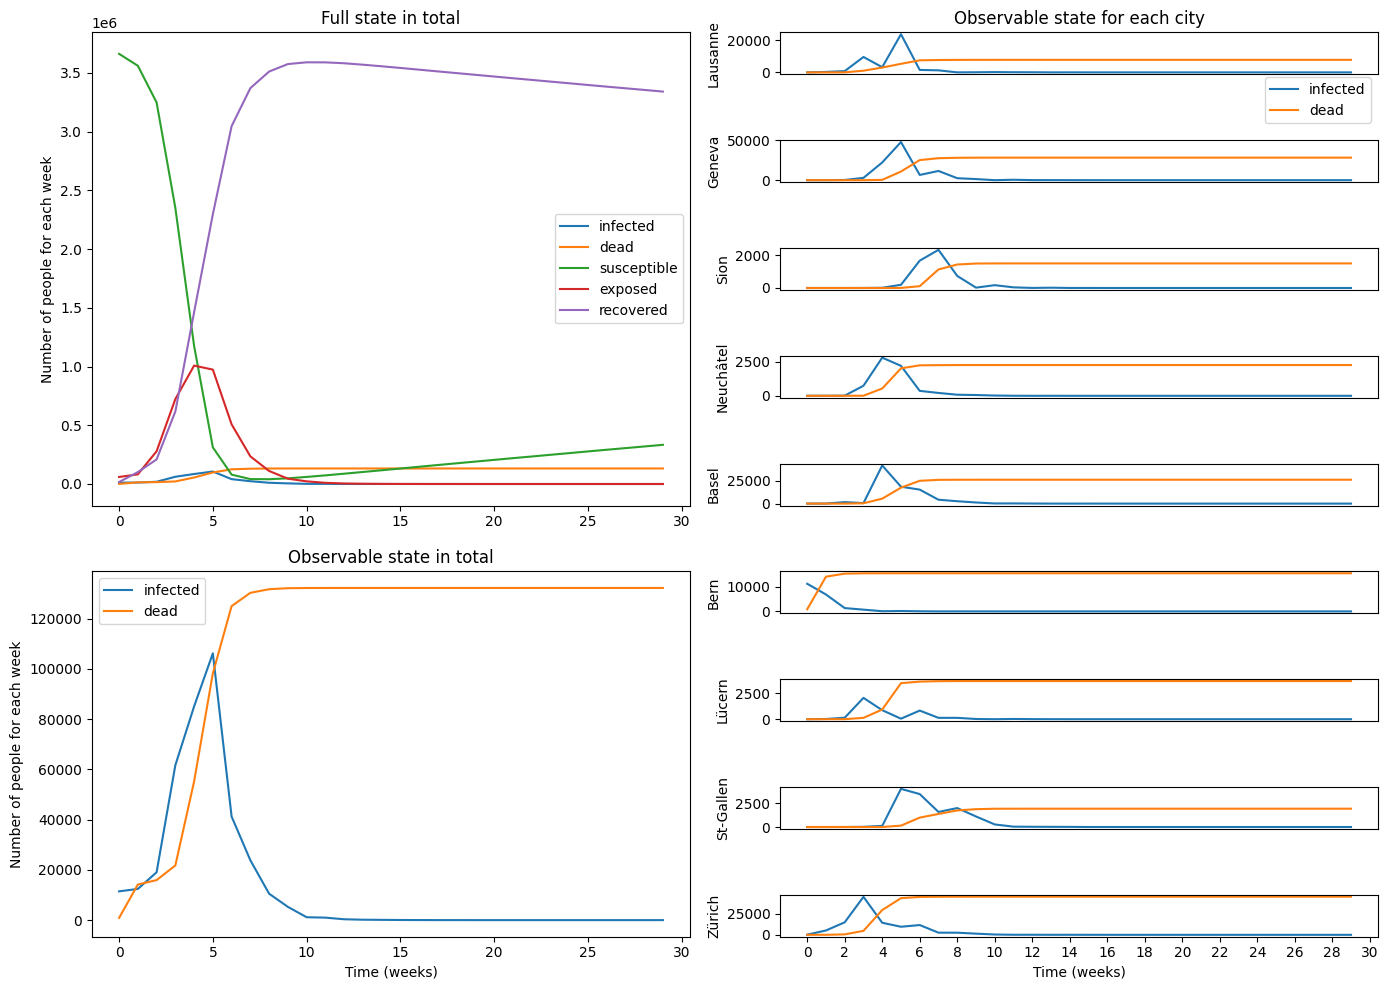

In [8]:
# Set the figure and the axes
fig = plt.figure(figsize=(14, 10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=5)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(5, 0), rowspan=4)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1, 9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

# 1.1 A plot of variables s[w] total, e[w] total, i[w] total, r[w] total, d[w] total over time
[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state in total')
ax_leftstate.set_ylabel('Number of people for each week')

# 1.2 A plot of variables i[w] total, d[w] total over time
[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state in total')
ax_leftobs.set_ylabel('Number of people for each week')
ax_leftobs.set_xlabel('Time (weeks)')

# 1.3 A set of plots of variables i[w] city, d[w] city over time (one subplot per-city)
infected_line = ax_right["Zürich"].plot(cities["Zürich"]['infected'], label="infected")[0]
dead_line = ax_right["Zürich"].plot(cities["Zürich"]['dead'], label="dead")[0]

for c, ax in ax_right.items():
    if c != "Zürich":
        ax.plot(cities[c]['infected'])
        ax.plot(cities[c]['dead'])

[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Lausanne'].set_title('Observable state for each city')
ax_right['Zürich'].set_xlabel('Time (weeks)')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

# Add a single overall legend for subplots in ax_right
legend = ax_right["Lausanne"].legend([infected_line, dead_line], ["infected", "dead"], loc="upper right", bbox_to_anchor=(1, 0.1))

fig.tight_layout()
plt.show()